In [43]:
import datetime
import pytz
from googleapiclient.errors import HttpError
from authenticate import authenticate_google_calendar 
import matplotlib.pyplot as plt

def get_all_studying_hours(service, calendar_id):
    # Get the current local timezone
    local_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo

    # Get today's date in the correct format
    today_start = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    today_end = datetime.datetime.now().replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()
    
    # Fetch events happening today
    try:
        events_result = service.events().list(calendarId=calendar_id, timeMin=today_start, timeMax=today_end, singleEvents=True, orderBy='startTime').execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return
    
    events = events_result.get('items', [])
    
    if not events:
        print("No events found for today.")
        return
    
    # Calculate total studying hours
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        start_time = datetime.datetime.fromisoformat(start)
        end_time = datetime.datetime.fromisoformat(end)
        duration = end_time - start_time
        total_hours += duration.total_seconds() / 3600
    
    print(f"Total studying hours scheduled for today: {total_hours:.2f} hours")
    return total_hours

def get_studying_hours_completed_today(service, calendar_id):
    # Get the current local timezone
    local_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo

    # Get today's date for the start of the day and current time
    today_start = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    now = datetime.datetime.now(tz=local_timezone).isoformat()

    # Fetch events happening today up until now
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=today_start,
                timeMax=now,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return

    events = events_result.get('items', [])

    if not events:
        print("No events found for today.")
        return

    # Calculate total studying hours
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        start_time = datetime.datetime.fromisoformat(start)
        end_time = datetime.datetime.fromisoformat(end)
        # Ensure the event has ended before adding to total hours
        if end_time <= datetime.datetime.now(tz=local_timezone):
            duration = end_time - start_time
            total_hours += duration.total_seconds() / 3600

    print(f"Total studying hours completed today: {total_hours:.2f} hours")
    return total_hours

In [44]:
def fetch_studying_hours(service, calendar_id, date):
    local_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()

    # Attempt to fetch events for the specified day
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=start_of_day,
                timeMax=end_of_day,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0  # Return 0 hours if an error occurs

    events = events_result.get('items', [])
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        # Parse the datetime strings into datetime objects
        start_time = datetime.datetime.fromisoformat(start)
        end_time = datetime.datetime.fromisoformat(end)
        # Calculate duration in hours
        duration = (end_time - start_time).total_seconds() / 3600
        total_hours += duration

    return total_hours

def plot_studying_progress(service, calendar_id):
    local_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
    now = datetime.datetime.now(tz=local_timezone)

    # Fetch data for the last week and last month
    days = 7
    monthly_days = 30
    daily_hours_week = []
    daily_hours_month = []
    dates_week = [now - datetime.timedelta(days=x) for x in range(days - 1, -1, -1)]
    dates_month = [now - datetime.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]

    for date in dates_week:
        daily_hours_week.append(fetch_studying_hours(service, calendar_id, date))

    for date in dates_month:
        daily_hours_month.append(fetch_studying_hours(service, calendar_id, date))

    # Get the total planned and completed studying hours for today
    planned_hours_today = get_all_studying_hours(service, calendar_id)
    completed_hours_today = get_studying_hours_completed_today(service, calendar_id)

    # Today's progress
    plt.figure(figsize=(10, 1))
    plt.barh(['Today'], [completed_hours_today], color='skyblue', label='Completed Hours')
    plt.barh(['Today'], [planned_hours_today - completed_hours_today], left=[completed_hours_today], color='lightgrey', label='Remaining Hours')
    plt.xlabel('Hours')
    plt.title('Today\'s Studying Progress')
    plt.legend()
    
    # Plotting the results for the last week
    plt.figure(figsize=(10, 5))
    plt.barh([date.strftime("%a %d") for date in reversed(dates_week)], daily_hours_week, color='skyblue')
    plt.xlabel('Hours Studied')
    plt.title('Studying Hours Over the Last Week')
    plt.tight_layout()
    plt.height = 0.5
    plt.show()

    # Plotting the results for the last month
    plt.figure(figsize=(10, 5))
    plt.barh([date.strftime("%b %d") for date in reversed(dates_month)], daily_hours_month, color='green')
    plt.xlabel('Hours Studied')
    plt.title('Studying Hours Over the Last Month')
    plt.tight_layout()
    plt.show()

Total studying hours scheduled for today: 4.67 hours
Total studying hours completed today: 2.00 hours


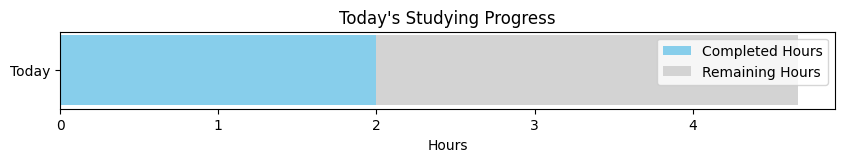

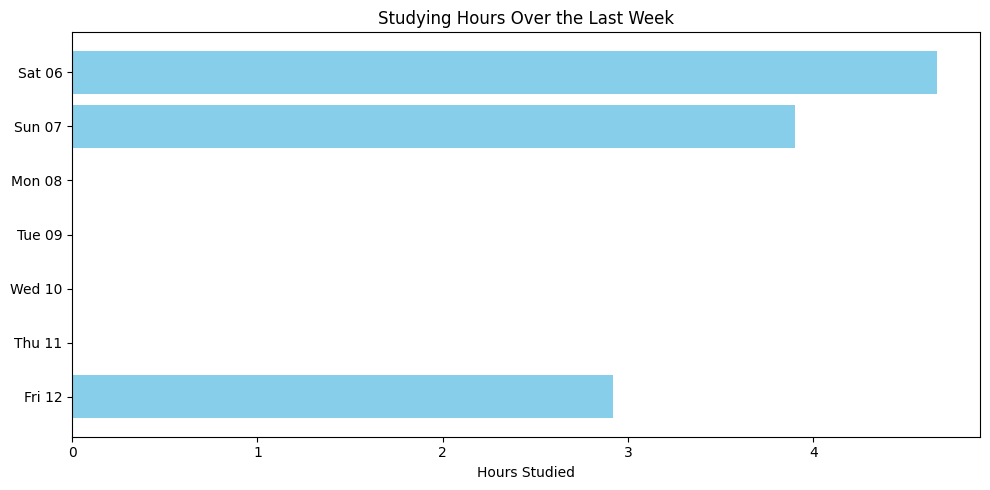

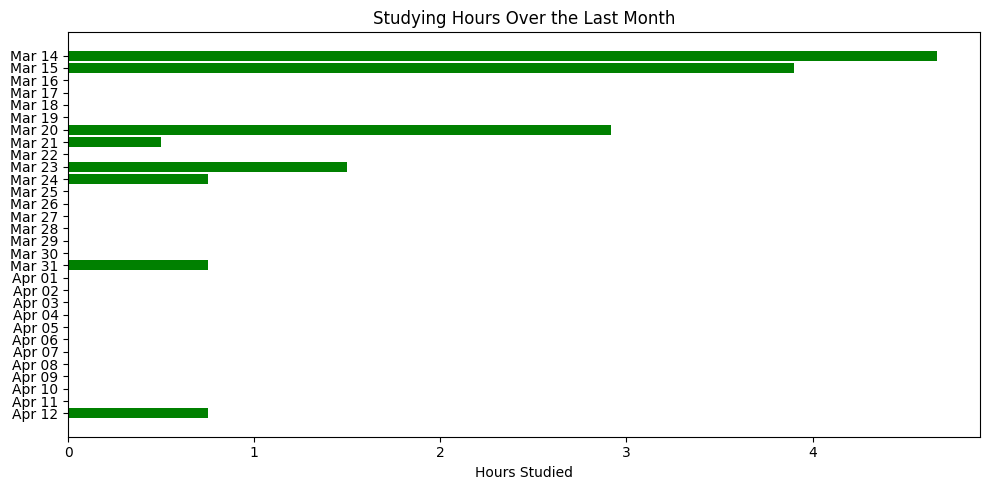

In [45]:
calendar_id = '0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com'

service = authenticate_google_calendar()  
plot_studying_progress(service, calendar_id)  # Replace 'your_calendar_id_here' with your actual studying calendar ID
